### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Scripts/Fake Folder Copy/Python Libraries')

from jb_libraries import *
from shipping_audit_data import *
%matplotlib inline

### Script settings

In [2]:
report_dict = {}

In [3]:
write_pdf = 'yes'
tableau_write = 'no'

now = dt.datetime.now().date()
now_pretty = str(now)

date_start = '2018-04-01'
date_end = '2019-04-30'

year_and_month_pretty = jb_dates(pd.Series(date_end[:7]),'year and month pretty')[0]

report_title = date_end[:4] + ' - ' + date_end[5:7] + ' - ' + calendar.month_abbr[int(date_end[5:7])] + ' - Monthly Shipping Audit'

image_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Shipping Audit/Images/Monthly/'

html_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Shipping Audit/HTML'
html_title = 'Monthly Shipping Audit.html'

pdf_path = '/Users/jarad/Scripts/Fake Folder Copy/Shipping/Recurring/Shipping Audit/Docs/Monthly Reports/'

style_sheet_path = '/Users/jarad/Scripts/Fake Folder Copy/CSS Stylesheets/Recurring Reports Stylesheet.css'

### Chart settings

In [4]:
ups_yellow = '#FCB900'
ups_brown = '#301504'

dhl_red = '#D2002E'
dhl_yellow = '#FFCC01'

usps_blue = '#333366'
usps_grey = '#F7F7F7'

### Get shipping audit data

In [5]:
main = get_shipping_audit_data(date_start, date_end)


== shipping audit data start ==


== shipping audit data end ==



### Fix state names

In [6]:
ls = ['city','state','country']
for col in ls:
    main['delivery %s' % col] = main['delivery %s' % col].str.strip()

# from http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
states = {'AK': 'Alaska',
          'AL': 'Alabama',
          'AR': 'Arkansas',
          'AS': 'American Samoa',
          'AZ': 'Arizona',
          'CA': 'California',
          'CO': 'Colorado',
          'CT': 'Connecticut',
          'DC': 'District of Columbia',
          'DE': 'Delaware',
          'FL': 'Florida',
          'GA': 'Georgia',
          'GU': 'Guam',
          'HI': 'Hawaii',
          'IA': 'Iowa',
          'ID': 'Idaho',
          'IL': 'Illinois',
          'IN': 'Indiana',
          'KS': 'Kansas',
          'KY': 'Kentucky',
          'LA': 'Louisiana',
          'MA': 'Massachusetts',
          'MD': 'Maryland',
          'ME': 'Maine',
          'MI': 'Michigan',
          'MN': 'Minnesota',
          'MO': 'Missouri',
          'MP': 'Northern Mariana Islands',
          'MS': 'Mississippi',
          'MT': 'Montana',
          'NA': 'National',
          'NC': 'North Carolina',
          'ND': 'North Dakota',
          'NE': 'Nebraska',
          'NH': 'New Hampshire',
          'NJ': 'New Jersey',
          'NM': 'New Mexico',
          'NV': 'Nevada',
          'NY': 'New York',
          'OH': 'Ohio',
          'OK': 'Oklahoma',
          'OR': 'Oregon',
          'PA': 'Pennsylvania',
          'PR': 'Puerto Rico',
          'RI': 'Rhode Island',
          'SC': 'South Carolina',
          'SD': 'South Dakota',
          'TN': 'Tennessee',
          'TX': 'Texas',
          'UT': 'Utah',
          'VA': 'Virginia',
          'VI': 'Virgin Islands',
          'VT': 'Vermont',
          'WA': 'Washington',
          'WI': 'Wisconsin',
          'WV': 'West Virginia',
          'WY': 'Wyoming'}

prov_terr = {'AB': 'Alberta',
             'BC': 'British Columbia',
             'MB': 'Manitoba',
             'NB': 'New Brunswick',
             'NL': 'Newfoundland and Labrador',
             'NT': 'Northwest Territories',
             'NS': 'Nova Scotia',
             'NU': 'Nunavut',
             'ON': 'Ontario',
             'PE': 'Prince Edward Island',
             'QC': 'Quebec',
             'SK': 'Saskatchewan',
             'YT': 'Yukon'}

states = {k.lower():v.lower() for k,v in states.items()}
prov_terr = {k.lower():v.lower() for k,v in prov_terr.items()}

In [7]:
def state_fix(df):
    
    state = df['delivery state']
    
    if df['delivery country'] == 'united states':
        
        if len(state) == 2 and state in list(states.keys()):
            return states[state]
        if len(state) == 2 and state not in list(states.keys()):
            return 'no state'
        else:
            return state
        
    elif df['delivery country'] == 'canada':

        if len(state) == 2 and state in list(prov_terr.keys()):
            return prov_terr[state]
        if len(state) == 2 and state not in list(prov_terr.keys()):
            return 'no state'
        else:
            return state
    
    else:
        return df['delivery state']
    
main['delivery state'] = main.apply(state_fix, axis = 1)

### Missing

In [8]:
missing_main = main[main['missing'] == 'yes'].copy()

### Total missing per service

In [9]:
missing_main.groupby(['year and month','shipping module code'])[['shipping module code']].count().unstack(1).fillna(0)

shipping module code      
shipping module code                  DHL   UPS
year and month                                 
2018-04                               0.0   9.0
2018-05                               1.0   7.0
2018-06                               1.0   5.0
2018-07                               1.0   7.0
2018-08                               1.0   4.0
2018-09                               0.0   4.0
2018-10                               2.0   7.0
2018-11                               2.0  13.0
2018-12                               0.0  31.0
2019-01                               2.0   8.0
2019-02                               1.0   3.0
2019-03                               0.0  18.0
2019-04                               2.0   8.0

### Exclude missing

In [10]:
main_clean = main[main['missing'] == 'no'].copy()

### Check totals and nulls

In [11]:
if len(main_clean) + len(missing_main) != len(main):
    raise ValueError('check ur totals')
    
if np.sum(main_clean.isnull().any(1)) > 0:
    raise ValueError('check ur nulls')    

### Write to Excel for Tableau

In [12]:
for_tab = main_clean.copy()

for_tab.drop(for_tab[for_tab['shipping charge'] == 0].index, inplace = True)
for_tab.reset_index(drop = True, inplace = True)

ls = ['year and month',
     'year and quarter',
     'missing']

for_tab.drop(ls, 1, inplace = True)

for col in for_tab.columns:    
    if col == 'shipping module code':
        pass
    elif for_tab[col].dtype == 'O':
        for_tab[col] = for_tab[col].str.title()
        
for_tab.columns = for_tab.columns.str.title()
for_tab.rename(columns = {'Shipping Module Code':'Service',
                         'Orders Id':'Orders ID',
                         'Ddp Revenue':'DDP Revenue',
                         'Ddp Charge':'DDP Charge'}, inplace = True)        

np.random.seed(1)
N = np.random.uniform(1,20)

for col in for_tab:
    if for_tab[col].dtype == 'int64':
        for_tab[col] = for_tab[col] * np.int((np.round(N)))
    elif for_tab[col].dtype == 'float64':
        for_tab[col] = for_tab[col] * N
    else:
        pass
    
for x in ['Service','Customer']:

    ls1 = list(set(for_tab[x]))

    ls2 = []
    for i in range(len(ls1)):
        ls2.append(i)

    d = {k:'%s Type %s' % (x, str(v)) for k,v in zip(ls1, ls2)}

    for_tab[x] = for_tab[x].map(d)    

if tableau_write == 'yes':
    writer = pd.ExcelWriter('/Users/jarad/Fake Folder/Shipping/Recurring/Shipping Audit/Tableau/Shipping Data for Tableau.xlsx', engine = 'xlsxwriter')
    for_tab.to_excel(writer, index = False)
    writer.save()

### Overall summary

,six month avg,YoY % Change
Shipping Revenue,"$284,136",-7.87%
Shipping Charge,"$257,821",-10.10%
Shipping Profit,"$27,157",24.50%
Order Count,"22,254",-6.92%
Profit Per Order,$1.22,33.76%
Margin,9.6%,35.15%


,Shipping Revenue,Shipping Charge,Shipping Profit,Order Count,Profit Per Order,Margin
year and month,,,,,,
2018-11,"$298,318","$272,762","$26,708","23,192",$1.15,9.0%
2018-12,"$264,972","$242,157","$24,205","20,836",$1.16,9.1%
2019-01,"$296,864","$267,933","$30,294","23,238",$1.30,10.2%
2019-02,"$278,114","$251,129","$27,283","21,514",$1.27,9.8%
2019-03,"$289,353","$263,254","$26,576","23,281",$1.14,9.2%
2019-04,"$277,194","$249,691","$27,874","21,462",$1.30,10.1%


Overall shipping revenue reached $277,194, and shipping profit hit $27,874 for a margin of 10.1%, about equal to the six month average of 9.6%. Shipping profit per order amounted to $1.30, up from last year's $0.97. Check out the chart below for shipping revenue and order counts over time.


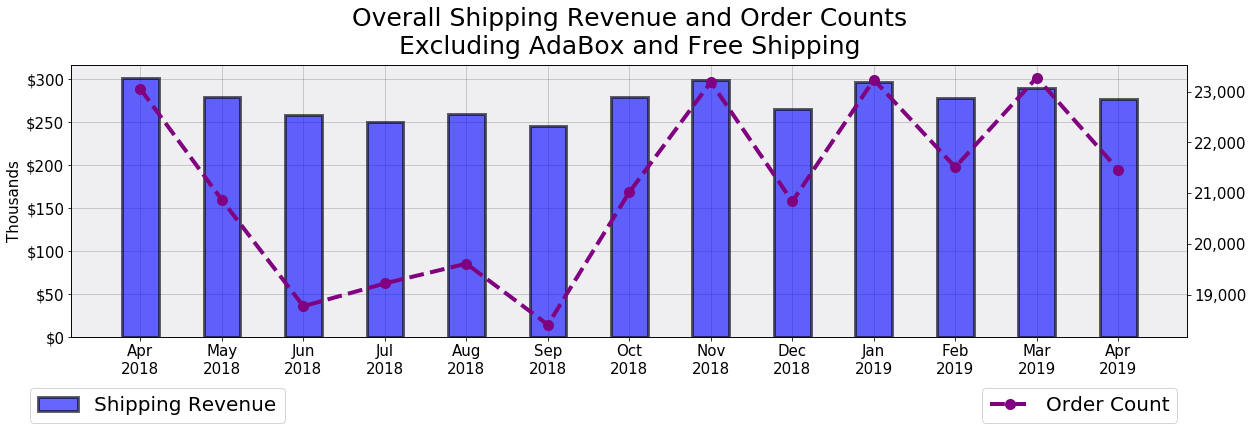

In [13]:
#==================================================
# Data table
#==================================================

df = main_clean[(main_clean['free shipping'] == 'no')
              & (main_clean['adabox'] == 'no')].groupby('year and month').agg({'shipping revenue':'sum',
                                                                               'shipping charge':'sum',
                                                                               'shipping profit':'sum',
                                                                               'orders id':'count'})
df.rename(columns = {'orders id':'order count'}, inplace = True)
df['profit per order'] = df['shipping profit']/df['order count']
df['margin'] = df['shipping profit']/df['shipping revenue']

fmt = ['m0','m0','m0','n0','m2','p1']

mean = jb_mean(df.tail(6), fmt)
mean.columns = ['six month avg']

yoy = jb_yoy(df)
yoy.columns = ['YoY % Change']

display(mean.join(yoy))
display(df.tail(6).format_(fmt))

#==================================================
# Summary for report
#==================================================

x = 'Overall'

revenue = df.iloc[-1]['shipping revenue']
profit = df.iloc[-1]['shipping profit']

prev_profit_per_order = df.iloc[0]['profit per order']
cur_profit_per_order = df.iloc[-1]['profit per order']

if np.abs(cur_profit_per_order - prev_profit_per_order) < 0.25:
    profit_res = 'about equal to'
else:
    if cur_profit_per_order > prev_profit_per_order:
        profit_res = 'up from'
    else:
        profit_res = 'down from'

margin = np.round(df.iloc[-1]['margin'], 4)
margin_mean = np.round(np.mean(df['margin'].tail(6)), 4)

if np.abs(margin - margin_mean) < 0.01:
    margin_res = 'about equal to'
else:
    if margin > margin_mean:
        margin_res = 'greater than'
    else:
        margin_res = 'less than'

w = '{} shipping revenue reached ${:,.0f}, and shipping profit hit ${:,.0f} \
for a margin of {:,.1f}%, {} the six month average of {:,.1f}%. Shipping profit per order \
amounted to ${:,.2f}, {} last year\'s ${:,.2f}. Check out the chart below for \
shipping revenue and order counts over time.'.format(x,
                                                     revenue,
                                                     profit,
                                                     margin * 100,
                                                     margin_res,
                                                     margin_mean * 100,
                                                     cur_profit_per_order,
                                                     profit_res,
                                                     prev_profit_per_order)

report_dict[x + ' write'] = w

print(report_dict[x + ' write'])

#==================================================
# Chart
#==================================================

fig, ax = plt.subplots(figsize = (20,5))

x1 = range(len(df))
y1 = df['shipping revenue']
y2 = df['order count']

width = 0.45

ax.bar(x1, y1, 
        width = width,
        color = 'blue',
        alpha = 0.60,
        edgecolor = 'black',
        lw = 3,
        zorder = 5)

ax2 = ax.twinx()
ax2.plot(x1, y2, color = 'purple', lw = 4, ls = '--', marker = 'o', mew = 5)

ax.set_title('Overall Shipping Revenue and Order Counts\nExcluding AdaBox and Free Shipping', fontsize = 25, y = 1.02)
ax.grid(color = 'black', alpha = 0.2)
ax.set_xticks(x1)

xticks = jb_dates(pd.Series(df.index), 'year and month xticks')
ax.set_xticklabels(xticks, fontsize = 15)
ax.set_xlabel('')

ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()], fontsize = 15)
ax.set_ylabel('Thousands', fontsize = 15)
ax.legend(['Shipping Revenue'], fontsize = 20, bbox_to_anchor = (0.20,-0.15))

ax2.legend(['Order Count'], fontsize = 20, bbox_to_anchor = (1,-0.15))
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in ax2.get_yticks()], fontsize = 15)

ax.set_facecolor('#efeff2')

plt.savefig(image_path + 'Overall Shipping Revenue and Order Counts', bbox_inches = 'tight')
plt.show()

### UPS, DHL, USPS summaries

UPS


,six month avg,YoY % Change
Shipping Revenue,"$156,201",-10.44%
Shipping Charge,"$151,794",-11.14%
Shipping Profit,"$3,871",31.60%
Order Count,"11,332",-12.22%
Profit Per Order,$0.34,49.92%
Margin,2.5%,46.93%


,Shipping Revenue,Shipping Charge,Shipping Profit,Order Count,Profit Per Order,Margin
year and month,,,,,,
2018-11,"$159,540","$155,053","$3,840","11,884",$0.32,2.4%
2018-12,"$148,895","$145,127","$3,351","10,689",$0.31,2.3%
2019-01,"$159,756","$154,350","$4,881","11,342",$0.43,3.1%
2019-02,"$155,042","$149,580","$4,914","11,129",$0.44,3.2%
2019-03,"$157,752","$154,833","$2,377","11,681",$0.20,1.5%
2019-04,"$156,220","$151,820","$3,865","11,267",$0.34,2.5%




UPS shipping revenue reached $156,220, and shipping profit hit $3,865     for a margin of 2.5%, about equal to the six month average of 2.5%. Shipping profit per order     amounted to $0.34, about equal to last year's $0.23. Check out the chart below for     shipping revenue and order counts over time.


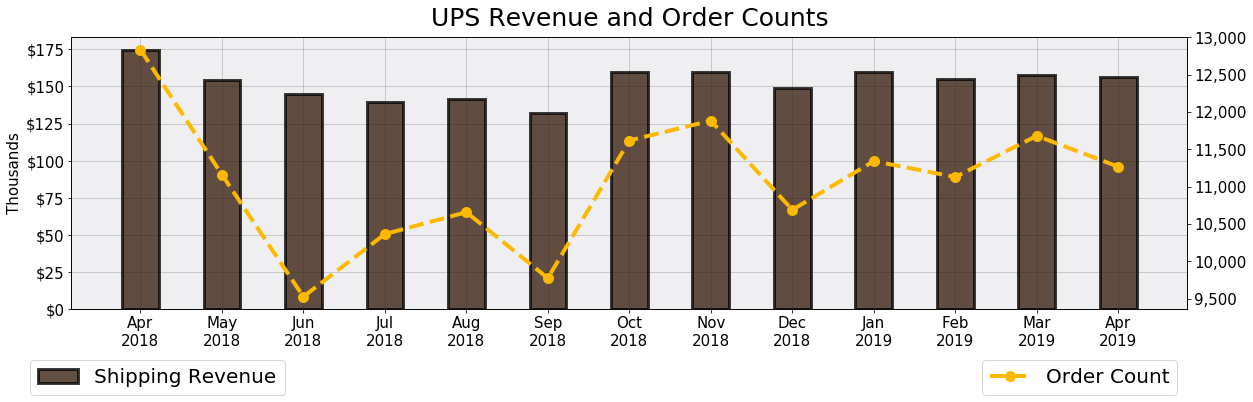

DHL


,six month avg,YoY % Change
Shipping Revenue,"$72,185",-16.12%
Shipping Charge,"$66,559",-21.01%
Shipping Profit,"$5,633",85.23%
Order Count,"1,627",-36.27%
Profit Per Order,$3.49,190.66%
Margin,7.8%,120.84%


,Shipping Revenue,Shipping Charge,Shipping Profit,Order Count,Profit Per Order,Margin
year and month,,,,,,
2018-11,"$85,052","$79,271","$5,770","1,915",$3.01,6.8%
2018-12,"$67,001","$61,955","$5,025","1,521",$3.30,7.5%
2019-01,"$76,837","$70,106","$6,734","1,677",$4.02,8.8%
2019-02,"$67,726","$62,886","$4,883","1,523",$3.21,7.2%
2019-03,"$70,326","$65,723","$4,627","1,672",$2.77,6.6%
2019-04,"$66,170","$59,412","$6,761","1,453",$4.65,10.2%




DHL shipping revenue reached $66,170, and shipping profit hit $6,761     for a margin of 10.2%, greater than the six month average of 7.8%. Shipping profit per order     amounted to $4.65, up from last year's $1.60. Check out the chart below for     shipping revenue and order counts over time.


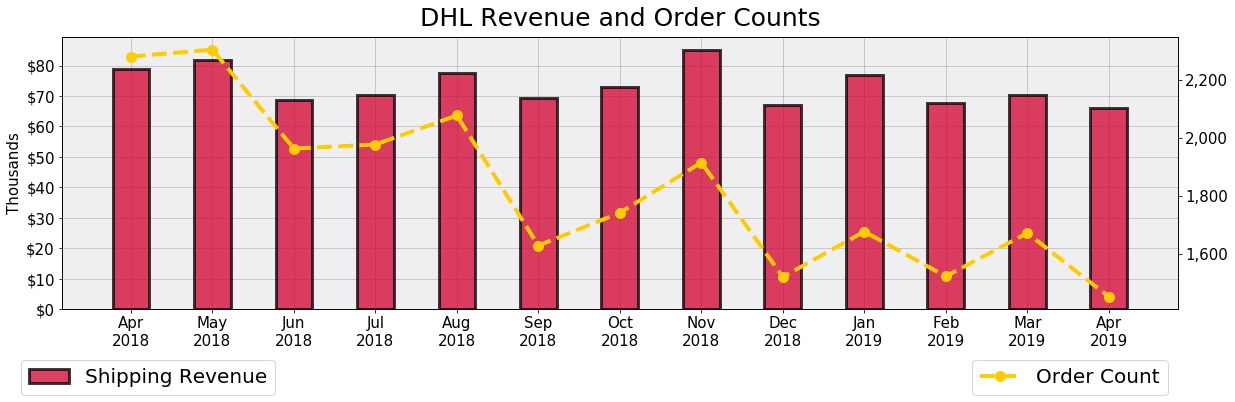

USPS


,six month avg,YoY % Change
Shipping Revenue,"$55,650",15.44%
Shipping Charge,"$39,469",21.41%
Shipping Profit,"$17,652",9.16%
Order Count,"9,292",10.12%
Profit Per Order,$1.90,-0.87%
Margin,31.7%,-5.44%


,Shipping Revenue,Shipping Charge,Shipping Profit,Order Count,Profit Per Order,Margin
year and month,,,,,,
2018-11,"$53,635","$38,438","$17,098","9,390",$1.82,31.9%
2018-12,"$48,956","$35,075","$15,829","8,622",$1.84,32.3%
2019-01,"$60,241","$43,477","$18,679","10,218",$1.83,31.0%
2019-02,"$55,196","$38,663","$17,486","8,857",$1.97,31.7%
2019-03,"$61,125","$42,698","$19,572","9,923",$1.97,32.0%
2019-04,"$54,744","$38,460","$17,248","8,740",$1.97,31.5%




USPS shipping revenue reached $54,744, and shipping profit hit $17,248     for a margin of 31.5%, about equal to the six month average of 31.7%. Shipping profit per order     amounted to $1.97, about equal to last year's $1.99. Check out the chart below for     shipping revenue and order counts over time.


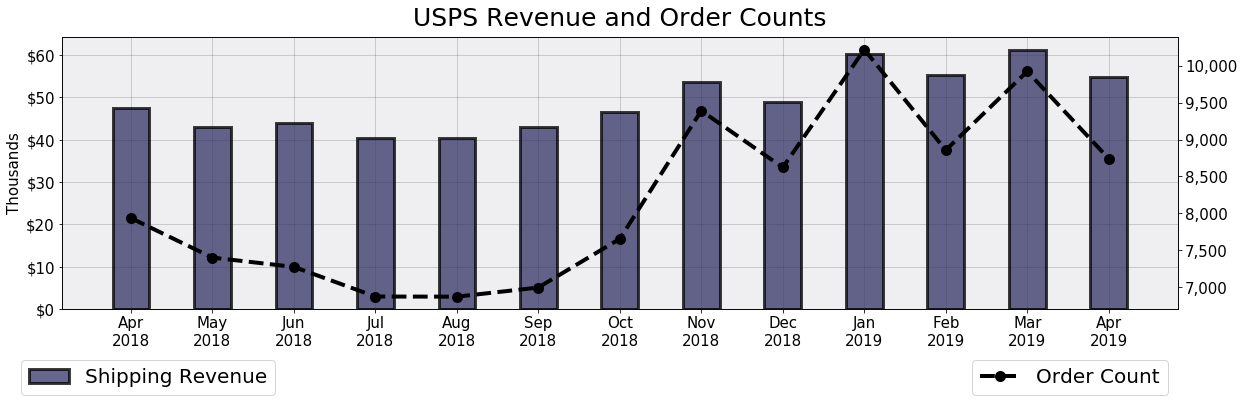

In [14]:
#==================================================
# Data table
#==================================================

colors = {'UPS':[ups_brown,ups_yellow],
          'DHL':[dhl_red, dhl_yellow],
          'USPS':[usps_blue, 'black']}

ls = ['UPS','DHL','USPS']
for x in ls:

    df = main_clean[(main_clean['shipping module code'] == x)
                  & (main_clean['free shipping'] == 'no')
                  & (main_clean['adabox'] == 'no')].groupby('year and month').agg({'shipping revenue':'sum',
                                                                              'shipping charge':'sum',
                                                                              'shipping profit':'sum',
                                                                              'orders id':'count'})
    df.rename(columns = {'orders id':'order count'}, inplace = True)
    df['profit per order'] = df['shipping profit']/df['order count']
    df['margin'] = df['shipping profit']/df['shipping revenue']    
    df['margin'] = np.where(df['margin'] < 0, 0, df['margin'])

    fmt = ['m0','m0','m0','n0','m2','p1']
    print(x.upper())

    mean = jb_mean(df.tail(6), fmt)
    mean.columns = ['six month avg']

    yoy = jb_yoy(df)
    yoy.columns = ['YoY % Change']

    display(mean.join(yoy))
    display(df.tail(6).format_(fmt))
    print('\n')    
    
#==================================================
# For report summary
#==================================================    
    
    revenue = df.iloc[-1]['shipping revenue']
    profit = df.iloc[-1]['shipping profit']

    prev_profit_per_order = df.iloc[0]['profit per order']
    cur_profit_per_order = df.iloc[-1]['profit per order']

    if np.abs(cur_profit_per_order - prev_profit_per_order) < 0.25:
        profit_res = 'about equal to'
    else:
        if cur_profit_per_order > prev_profit_per_order:
            profit_res = 'up from'
        else:
            profit_res = 'down from'

    margin = np.round(df.iloc[-1]['margin'], 4)
    margin_mean = np.round(np.mean(df['margin'].tail(6)), 4)

    if np.abs(margin - margin_mean) < 0.01:
        margin_res = 'about equal to'
    else:
        if margin > margin_mean:
            margin_res = 'greater than'
        else:
            margin_res = 'less than'

    w = '{} shipping revenue reached ${:,.0f}, and shipping profit hit ${:,.0f} \
    for a margin of {:,.1f}%, {} the six month average of {:,.1f}%. Shipping profit per order \
    amounted to ${:,.2f}, {} last year\'s {}. Check out the chart below for \
    shipping revenue and order counts over time.'.format(x,
                                                         revenue,
                                                         profit,
                                                         margin * 100,
                                                         margin_res,
                                                         margin_mean * 100,
                                                         cur_profit_per_order,
                                                         profit_res,
                                                         '-${:,.2f}'.format(np.abs(prev_profit_per_order)) if prev_profit_per_order < 0 else '${:,.2f}'.format(prev_profit_per_order))
    report_dict[x + ' write'] = w

    print(report_dict[x + ' write'])
    
#==================================================
# Chart
#==================================================    

    fig, ax = plt.subplots(figsize = (20,5))

    x1 = range(len(df))
    y1 = df['shipping revenue']
    y2 = df['order count']

    width = 0.45

    ax.bar(x1, y1, 
           width = width, 
           color = colors[x][0], 
           edgecolor = 'black',
           zorder = 5,
           alpha = 0.75,
           lw = 3)
    ax.set_title(x.upper() + ' Revenue and Order Counts', fontsize = 25, y = 1.02)
    ax.grid(color = 'black', alpha = 0.2)    
    ax.set_ylabel('Thousands', fontsize = 15)
    ax.legend(['Shipping Revenue'], bbox_to_anchor = (0.2, -0.15), fontsize = 20)
    ax.set_facecolor('#efeff2')

    ax2 = ax.twinx()
    ax2.plot(x1, y2, color = colors[x][1], lw = 4, ls = '--', marker = 'o', mew = 5)
    ax2.set_yticklabels(['{:,.0f}'.format(x) for x in ax2.get_yticks()], fontsize = 15)
    ax2.legend(['Order Count'], bbox_to_anchor = (1, -0.15), fontsize = 20)

    ax.set_xticks(x1)
    xticks = jb_dates(pd.Series(df.index), 'year and month' + ' xticks')
    ax.set_xticklabels(xticks, fontsize = 15)
    ax.set_xlabel('')    
    ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()], fontsize = 15)    

    plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
    plt.show()        

### Free shipping

In [15]:
free_main = main_clean[(main_clean['free shipping'] == 'yes')
                      & (main_clean['adabox'] == 'no')].copy()

six month avg


,mean
Non Reseller,"$17,275"
Reseller/Super,"$6,671"
Total Excluding Adabox,"$23,946"
Subtotal,"$1,835,154"
Avg Subtotal,"$1,022"
Order Count,"1,802"
Total As % Of Subtotal,1.3%
Non Reseller Shipping Charge %,72.2%
Reseller/Super Shipping Charge %,27.8%
Adabox Charge,"$15,807"


,Non Reseller,Reseller/Super,Total Excluding Adabox,Subtotal,Avg Subtotal,Order Count,Total As % Of Subtotal,Non Reseller Shipping Charge %,Reseller/Super Shipping Charge %,Adabox Charge,Adabox OID Count,Adabox Charge Per OID,Totals Including Adabox
year and month,,,,,,,,,,,,,
2018-11,"$19,578","$6,405","$25,983","$1,890,686",$939,"2,013",1.4%,75.3%,24.7%,"$42,155","3,451",$12.22,"$68,138"
2018-12,"$12,796","$6,337","$19,133","$1,570,898","$1,135","1,384",1.2%,66.9%,33.1%,"$3,690",291,$12.68,"$22,823"
2019-01,"$17,818","$5,979","$23,797","$1,693,712",$899,"1,884",1.4%,74.9%,25.1%,$0,0,$0.00,"$23,797"
2019-02,"$16,882","$4,820","$21,702","$1,712,554",$993,"1,724",1.3%,77.8%,22.2%,$0,0,$0.00,"$21,702"
2019-03,"$19,289","$9,758","$29,047","$2,341,247","$1,152","2,032",1.2%,66.4%,33.6%,"$48,984","3,818",$12.83,"$78,031"
2019-04,"$17,284","$6,729","$24,013","$1,801,830","$1,014","1,777",1.3%,72.0%,28.0%,$11,1,$10.88,"$24,024"


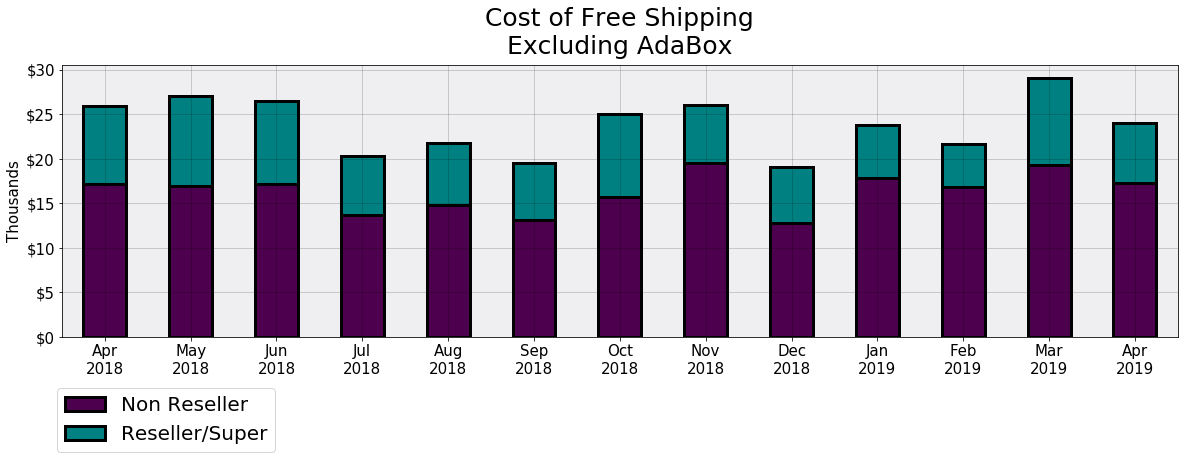

In [16]:
df1 = free_main.groupby(['year and month','customer'])[['shipping charge']].sum().unstack(1).fillna(0)
df1.columns = df1.columns.droplevel(0)
df1['total excluding adabox'] = df1.sum(1)

df2 = free_main.groupby('year and month').agg({'subtotal':['sum','mean','count']})
df2.columns = ['subtotal','avg subtotal','order count']

df3 = df1.join(df2)

df3['total as % of subtotal'] = df3['total excluding adabox']/df3['subtotal']

for x in ['non reseller','reseller/super']:
    df3[x + ' shipping charge %'] = df3[x]/df3['total excluding adabox']
    
df4 = main_clean[main_clean['adabox'] == 'yes'].groupby('year and month').agg({'shipping charge':'sum','orders id':'nunique'})
df4.columns = ['adabox charge','adabox OID count']
df4['adabox charge per OID'] = df4['adabox charge']/df4['adabox OID count']

df5 = df3.join(df4).fillna(0)
df5['totals including adabox'] = df5['total excluding adabox'] + df5['adabox charge']

print('six month avg')
fmt = ['m0'] * 5 + ['n0','p1','p1','p1','m0','n0','m2','m0']
display(jb_mean(df5.tail(6), fmt))
display(df5.format_(fmt).tail(6))

fig, ax = plt.subplots()

x = range(len(df5))
y1 = df5['non reseller']
y2 = df5['reseller/super']

chart = df5[['non reseller','reseller/super']]
chart.columns = [x.title() for x in chart.columns]

chart.plot(ax = ax,
           kind = 'bar',
           color = ['#4d004d','#008080'],
           stacked = True,
           edgecolor = 'black',
           lw = 3,
           rot = 0,
           figsize = (20,5))

ax.legend(bbox_to_anchor = (0.2, -0.15), fontsize = 20)
ax.set_title('Cost of Free Shipping\nExcluding AdaBox', y = 1.02,fontsize = 25)
vals = ax.get_yticks()
ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in vals], fontsize = 15)
ax.set_ylabel('Thousands', fontsize = 15)

ax.set_xticks(x)
ax.set_xlabel('')
xticks = jb_dates(pd.Series(df5.index), 'year and month xticks')
ax.set_xticklabels(xticks, fontsize = 15, rotation = 0)
ax.grid(color = 'black', alpha = 0.2)
ax.set_facecolor('#efeff2')
plt.savefig(image_path + 'Cost of Free Shipping', bbox_inches = 'tight')
plt.show()

### YTD Free Shipping

In [17]:
year = free_main['date purchased'].max().year
ytd_main = free_main[(free_main['date purchased'].dt.year == year)
                   & (free_main['adabox'] == 'no')]

ytd = ytd_main['shipping charge'].sum()

print('YTD free shipping cost: ${:,.0f}'.format(ytd))

n = len(set(ytd_main['year and month']))
ytd_avg = ytd/n
print('that\'s an average of ${:,.0f} per month'.format(ytd_avg))

YTD free shipping cost: $98,559
that's an average of $24,640 per month


### Free shipping for report

In [18]:
a = np.round(df5.iloc[-1]['total excluding adabox'])
b = np.round(np.mean(df5['total excluding adabox'].tail(6)))

if a < b:
    res = 'below'
elif a > b:
    res = 'above'
else:
    res = 'equal to'
    
free_01 = 'The cost of free shipping amounted to ${:,.0f}, {} the six month average of \
${:,.0f}. Year to date, the cost of free shipping is ${:,.0f}.'.format(a,res,b,ytd)
report_dict['free 01'] = free_01
report_dict['free 01']

'The cost of free shipping amounted to $24,013, above the six month average of $23,946. Year to date, the cost of free shipping is $98,559.'

In [19]:
a = df5.iloc[-1]['subtotal']
b = np.round(df5.iloc[-1]['total as % of subtotal'], 4)
c = np.round(np.mean(df5['total as % of subtotal'].tail(6)), 4)

if np.abs(b-c) < 0.01:
    res = 'about equal to'
else:
    if b < c:
        res = 'below'
    else:
        res = 'above'
        
free_02 = 'The part revenue generated from orders which received free shipping was ${:,.0f}, \
making the cost of free shipping just {:,.1f}% of revenue, which is {} the six month \
average of {:,.1f}%.'.format(a,b * 100, res, c * 100)        

report_dict['free 02'] = free_02
report_dict['free 02']

'The part revenue generated from orders which received free shipping was $1,801,830, making the cost of free shipping just 1.3% of revenue, which is about equal to the six month average of 1.3%.'

In [20]:
a = df5.iloc[-1]['avg subtotal']
b = df5.iloc[0]['avg subtotal']

if a > b:
    res = 'higher'
else:
    res = 'lower'

free_03 = 'The average subtotal value for orders which received free shipping came in at ${:,.0f}, \
{} than last year’s ${:,.0f}.'.format(a,res,b)    

report_dict['free 03'] = free_03
report_dict['free 03']    

'The average subtotal value for orders which received free shipping came in at $1,014, lower than last year’s $1,045.'

In [21]:
a = df5['non reseller shipping charge %'].mean()

free_04 = 'The chart below shows the cost of free shipping broken down by customer type, where \
Non Resellers typically make up {:,.0f}% on average, while Resellers and Supers make up the \
remaining {:,.0f}%.'.format(a * 100, (1-a) * 100)

report_dict['free 04'] = free_04
report_dict['free 04']    

'The chart below shows the cost of free shipping broken down by customer type, where Non Resellers typically make up 69% on average, while Resellers and Supers make up the remaining 31%.'

### Free Shipping Proportions

In [22]:
a = df5[['non reseller','reseller/super']]
b = a.sum(1)
c = a.div(b, axis = 0)

fmt = ['p1','p1']
display(jb_mean(c, fmt))
c.tail(6).format_(fmt)

,mean
Non Reseller,68.7%
Reseller/Super,31.3%


,Non Reseller,Reseller/Super
year and month,,
2018-11,75.3%,24.7%
2018-12,66.9%,33.1%
2019-01,74.9%,25.1%
2019-02,77.8%,22.2%
2019-03,66.4%,33.6%
2019-04,72.0%,28.0%


### Losses only

In [23]:
loss_main = main_clean[(main_clean['profit loss'] == 'yes') & (main_clean['adabox'] == 'no')].copy()

loss = loss_main.groupby(['year and month','shipping module code'])[['shipping profit']].sum().unstack().fillna(0)
loss.columns = loss.columns.droplevel(0)
loss['total'] = loss.sum(1)

count = main_clean.groupby('year and month')[['orders id']].count()
loss['avg loss per order'] = loss['total']/count['orders id']

revenue = main.groupby('year and month')[['shipping revenue']].sum()
loss['avg loss per revenue'] = loss['total']/revenue['shipping revenue']

gained = main_clean[main_clean['profit loss'] == 'no'].groupby(['year and month']).agg({'shipping revenue':'sum','orders id':'count'}).rename(columns = {'orders id':'oid count'})
gained['avg revenue per order'] = gained['shipping revenue']/gained['oid count']    

loss = loss.join(gained[['avg revenue per order']])

fmt = ['m0','m0','m0','m0','m2','m2','m2']

mean = jb_mean(loss.tail(6), fmt)
mean.columns = ['six month avg']

yoy = jb_yoy(loss)
yoy.columns = ['YoY % Change']

display(mean.join(yoy))
display(loss.format_(fmt))

,six month avg,YoY % Change
DHL,"$-3,345",-46.72%
UPS,"$-26,709",-15.80%
USPS,$-289,-36.48%
Total,"$-30,343",-19.73%
Avg Loss Per Order,$-1.20,-14.10%
Avg Loss Per Revenue,$-0.11,-12.86%
Avg Revenue Per Order,$12.06,3.25%


,DHL,UPS,USPS,Total,Avg Loss Per Order,Avg Loss Per Revenue,Avg Revenue Per Order
year and month,,,,,,,
2018-04,"$-4,396","$-31,554",$-318,"$-36,268",$-1.46,$-0.12,$11.97
2018-05,"$-4,536","$-32,498",$-278,"$-37,312",$-1.65,$-0.13,$12.19
2018-06,"$-4,316","$-30,527",$-289,"$-35,132",$-1.72,$-0.14,$12.52
2018-07,"$-4,261","$-22,866",$-198,"$-27,325",$-1.11,$-0.11,$11.90
2018-08,"$-4,233","$-24,634",$-318,"$-29,185",$-1.37,$-0.11,$12.12
2018-09,"$-3,979","$-21,981",$-227,"$-26,187",$-1.12,$-0.11,$12.42
2018-10,"$-4,142","$-28,247",$-212,"$-32,601",$-1.43,$-0.12,$12.49
2018-11,"$-4,416","$-29,224",$-366,"$-34,006",$-1.19,$-0.11,$12.01
2018-12,"$-3,554","$-21,878",$-260,"$-25,692",$-1.14,$-0.10,$11.96


### Losses for report

In [24]:
a = np.abs(loss.iloc[-1]['total'])
b = np.abs(np.mean(loss['total'].tail(6)))    

if a < b:
    res1 = 'lower than'
elif a > b:
    res1 = 'higher than'
else:
    res1 = 'equal to'

c = np.round(np.abs(loss.iloc[-1]['avg loss per revenue']),2)
d = np.round(np.abs(np.mean(loss['avg loss per revenue'].tail(6))),2)
    
if np.abs(c-d) < 0.05:
    res2 = 'about equal to'
else:    
    if c < d:
        res2 = 'lower than'
    else:
        res2 = 'higher than'
    
loss_write = 'When we focus only on orders which incurred a shipping profit loss, the total amount lost \
comes to ${:,.0f}, {} the six month average of \
${:,.0f}. When this total amount lost is averaged over all shipping revenue gained, the average loss \
per dollar of revenue comes to ${:,.2f}, {} the average of ${:,.2f}. Note that the overall \
shipping profit was strong and positive; this section here is only talking about orders which \
incurred a loss.'.format(a, res1, b, c, res2, d)

report_dict['loss write'] = loss_write
report_dict['loss write']    

'When we focus only on orders which incurred a shipping profit loss, the total amount lost comes to $29,113, lower than the six month average of $30,343. When this total amount lost is averaged over all shipping revenue gained, the average loss per dollar of revenue comes to $0.10, about equal to the average of $0.11. Note that the overall shipping profit was strong and positive; this section here is only talking about orders which incurred a loss.'

### Just AdaBox

In [25]:
ada_main = main_clean[main_clean['adabox'] == 'yes'].copy()

by_s = ada_main.groupby('delivery state', sort = False)[['shipping profit']].sum().sort_values('shipping profit').head()
by_s['% of total'] = by_s['shipping profit']/by_s['shipping profit'].sum()
by_s.format_(['m0','p1'])

ix = sorted(list(set(main_clean['year and month'])))
dates = pd.DataFrame(index = ix)
dates.index.name = 'year and month'

by_m = ada_main.groupby('year and month').agg({'shipping charge':'sum','orders id':'nunique'})
by_m.columns = ['shipping charge','adabox order count']
by_m['shipping cost per box'] = by_m['shipping charge']/by_m['adabox order count']

by_m = (dates.join(by_m)).fillna(0)

fmt = ['m0','n0','m2']
display(jb_mean(by_m, fmt))
display(by_m.format_(fmt))

,mean
Shipping Charge,"$14,158"
Adabox Order Count,"1,154"
Shipping Cost Per Box,$6.46


,Shipping Charge,Adabox Order Count,Shipping Cost Per Box
year and month,,,
2018-04,$0,0,$0.00
2018-05,$0,0,$0.00
2018-06,$0,0,$0.00
2018-07,"$45,789","3,840",$11.92
2018-08,$0,0,$0.00
2018-09,"$43,171","3,577",$12.07
2018-10,$251,22,$11.43
2018-11,"$42,155","3,451",$12.22
2018-12,"$3,690",291,$12.68


In [26]:
if by_m.iloc[-1]['adabox order count'] == 0:
    w = 'There were no AdaBox shipments.'
else:
    a = by_m.iloc[-1]['adabox order count']
    b = by_m.iloc[-1]['shipping charge']
    c = by_m.iloc[-1]['shipping cost per box']
    
    w = 'The AdaBox shipment count hit x{:,.0f}, and the shipping charge reached \
    ${:,.0f}, which makes for an average shipping charge of ${:,.2f} per box.'.format(a,b,c)
    
report_dict['adabox write'] = w
report_dict['adabox write']

'The AdaBox shipment count hit x1, and the shipping charge reached     $11, which makes for an average shipping charge of $10.88 per box.'

### PDF Report

In [31]:
if write_pdf == 'yes':
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'year_and_month':year_and_month_pretty,
                    'now':now_pretty,
                    'overall_write':report_dict['Overall write'],
                    'ups_write':report_dict['UPS write'],
                    'dhl_write':report_dict['DHL write'],
                    'usps_write':report_dict['USPS write'],
                    'free_01':report_dict['free 01'],
                    'free_02':report_dict['free 02'],
                    'free_03':report_dict['free 03'],
                    'free_04':report_dict['free 04'],
                    'loss_write':report_dict['loss write'],
                    'adabox_write':report_dict['adabox write']}

    html_out = template.render(template_vars)

    from weasyprint import HTML

    HTML(string = html_out).write_pdf(pdf_path + report_title + '.pdf',
                                      stylesheets = [style_sheet_path])                               

In [32]:
print('done')

done
